In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time
import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
!pip install self_attention_cv
from self_attention_cv.bottleneck_transformer import BottleneckBlock

from torch.autograd import Variable

import torchvision
#from torchvision.datasets import MNIST

     |████████████████████████████████| 286kB 23.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [ ]:
# https://github.com/hanqingguo/deepfake-pytorch/blob/master/padding_same_conv.py
import torch.utils.data
from torch.nn import functional as F

import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple


class _ConvNd(Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


class Conv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


# custom con2d, because pytorch don't have "padding='same'" option.
def conv2d_same_padding(input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):

    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows -
                  input_rows)
    padding_rows = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    padding_cols = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    cols_odd = (padding_rows % 2 != 0)

    if rows_odd or cols_odd:
        input = pad(input, [0, int(cols_odd), 0, int(rows_odd)])

    return F.conv2d(input, weight, bias, stride,
                  padding=(padding_rows // 2, padding_cols // 2),
                  dilation=dilation, groups=groups)

# https://github.com/hanqingguo/deepfake-pytorch/blob/master/models.py
class _PixelShuffler(nn.Module):
    def forward(self, input):
        batch_size, c, h, w = input.size()
        rh, rw = (2, 2)
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)
        out = input.view(batch_size, rh, rw, oc, h, w)
        out = out.permute(0, 3, 4, 1, 5, 2).contiguous()
        out = out.view(batch_size, oc, oh, ow)  # channel first

        return out

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # print(kwargs["input_shape"])
        # self.encoder_hidden_layer = nn.Linear(
        #     in_features=kwargs["input_shape"], out_features=128
        # )
        # self.encoder_output_layer = nn.Linear(
        #     in_features=128, out_features=128
        # )
        # self.decoder_hidden_layer = nn.Linear(
        #     in_features=128, out_features=128
        # )
        # self.decoder_output_layer = nn.Linear(
        #     in_features=128, out_features=kwargs["input_shape"]
        # )

        # ENCODING

        # block 2 up
        self.en_conv1 = nn.Sequential(
            Conv2d(3,128, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            Conv2d(128,256, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            Conv2d(256,512, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            Conv2d(512,1024, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True)
        )

        # Linear Layer (AKA Dense)
        self.en_dense1 = nn.Linear(
            in_features=8*8*1024, out_features=1024
        )
        self.en_dense2 = nn.Linear(
            in_features=1024, out_features=8*8*1024
        )

        # upblock
        self.en_up = nn.Sequential(
            Conv2d(1024, 512, 
                      kernel_size=3),
            nn.LeakyReLU()
        )


        # DECODING
        self.de_up1 = nn.Sequential(
            Conv2d(512, 256 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler()
        )

        self.de_up2 = nn.Sequential(
            Conv2d(256, 128 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler(),
        )

        self.de_up3= nn.Sequential(
            Conv2d(128, 64 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler(),
        )
        self.de_up4= nn.Sequential(
            Conv2d(64, 32 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler(),
        )

        self.de_up5 = nn.Sequential(
            Conv2d(32, 3, kernel_size=5, padding=2)
        )


        self.de_up_tanh = nn.Sequential(
            nn.Tanh()
        )

        self.de_up_sig = nn.Sequential(
            nn.Sigmoid()
        )

    def forward(self, features):
        # activation = self.encoder_hidden_layer(features)
        # activation = torch.relu(activation)
        # code = self.encoder_output_layer(activation)
        # code = torch.relu(code)
        # activation = self.decoder_hidden_layer(code)
        # activation = torch.relu(activation)
        # activation = self.decoder_output_layer(activation)
        # reconstructed = torch.relu(activation)
        # return reconstructed

        # encoding
        # print('features',features.shape,'expected: (3,128,128)')

        x = self.en_conv1(features)
        # print('en_conv1',x.shape,'expected: (256,32,32)')
        # x = self.attention1(x)
        # print('en_attn1',x.shape)
        # print('en_conv1',x.shape)
        x = x.view(x.size(0), -1)
        # print('x flatten',x.shape)
        # print('flatten',x.shape,'expected: (65536)')
        x = self.en_dense1(x)
        # print('x dense',x.shape)
        # print('en_dense1',x.shape,'expected: (1024)')

        # x = torch.relu(x)
        # x = torch.flatten(x)
        x = self.en_dense2(x)
        # print('x dense 2',x.shape)
        # print('en_dense2',x.shape,'expected: (65536)')
        # x = torch.relu(x)
        x = x.view(-1, 1024, 8, 8)
        # print('x view',x.shape)
        x = self.en_up(x)
        # print('x en_up',x.shape)
        # print('en_up',x.shape,'expected: (8,8,512)')
        # print('done with encoding')

        # decoding
        x = self.de_up1(x)
        # print('x de_up1',x.shape)
        x = self.de_up2(x)
        # print('x de_up2',x.shape)
        x = self.de_up3(x)
        # print('x de_up3',x.shape)
        x = self.de_up4(x)
        # print('x de_up4',x.shape)
        x = self.de_up5(x)
        # print('x de_up5',x.shape)
        x = self.de_up_sig(x)

        return x



In [ ]:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/aae/aae.py
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (mu.size(0), 10))))
    z = sampled_z * std + mu
    return z


class Encoder(nn.Module):
    def __init__(self,img_shape):
        super(Encoder, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, 10)
        self.logvar = nn.Linear(512, 10)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self,img_shape):
        super(Decoder, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(10, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(self.img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *self.img_shape)
        return img


In [ ]:
class AEDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
      
        temp = []
        count = 0
        for filename in os.listdir(file_path):
            if filename.endswith(".jpg"):
                img = cv2.imread(file_path + '/'+filename)
                img = cv2.resize(img,(128,128))
                temp.append(img)

                if count % 100 == 0: print(str(count) + ' images done')

                count += 1
        print(len(temp))
        self.x = torch.tensor(temp,dtype=torch.float32)
        self.x = self.x.view(self.x.shape[0],3,self.x.shape[1],self.x.shape[2])
        print(self.x[0].shape)
        # self.x = torch.flatten(self.x,1)
        print(self.x.shape)
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image = self.x[idx].clone().detach()/255
        return image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# hyperparameters
epochs = 150
learning_rate = 0.001
batch_size = 100

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=3).to(device)
# encoder = Encoder((128,128,3))
# decoder = Decoder((128,128,3))
# encoder.cuda()
# decoder.cuda()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.L1Loss()

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JohnOliver1-cropped-real-face-crop')
# train_dataset = MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )
# /content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF
# test_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF')
test_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/Jimmy Fallon-face-crop')
# test_dataset = MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )
train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

0 images done
100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done
1600 images done
1700 images done
1800 images done
1900 images done
2000 images done
2020
torch.Size([3, 128, 128])
torch.Size([2020, 3, 128, 128])
0 images done
100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done
1600 images done
1700 images done
1722
torch.Size([3, 128, 128])
torch.Size([1722, 3, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
training_len = len(train_loader)
for epoch in range(epochs):
    loss = 0
    # model.train()
    for idx, batch_features in enumerate(train_loader):
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.cuda()
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        # encoded_imgs = encoder(batch_features)
        # decoded_imgs = decoder(encoded_imgs)
        # compute training reconstruction loss
        # print(outputs.shape,batch_features.shape)
        train_loss = criterion(outputs.view(batch_features.shape), batch_features)
        
        # compute accumultrain_loaderated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / training_len
    
    if(epoch % 20 ==0): print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
print("final loss = " + str(loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1/150, loss = 0.074963
epoch : 21/150, loss = 0.049015
epoch : 41/150, loss = 0.036983
epoch : 61/150, loss = 0.031532
epoch : 81/150, loss = 0.028364
epoch : 101/150, loss = 0.025896
epoch : 121/150, loss = 0.024459
epoch : 141/150, loss = 0.022539
final loss = 0.02197720757907345


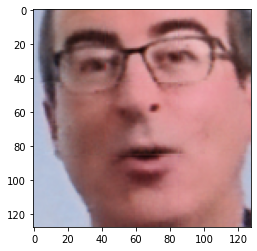

In [ ]:
img = cv2.cvtColor(((outputs[3].cpu().detach().view(128,128,3).numpy()*255)).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
test_examples = None
generated = []
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features.cuda()
        test_examples = batch_features.view(-1, 128*128*3).cuda()
        reconstruction = model(batch_features).cpu()
        generated.append(reconstruction)
print(type(generated[0]))
generated = torch.cat(generated)
print(generated.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'torch.Tensor'>
torch.Size([1722, 3, 128, 128])


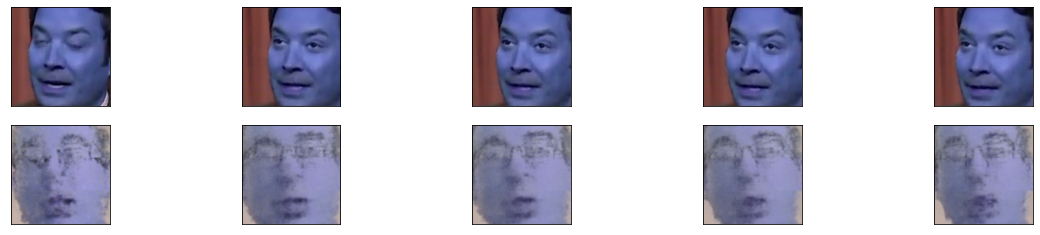

In [ ]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow((test_examples[index].cpu().detach().numpy().reshape(128, 128, 3)*(255)).astype(np.uint8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(((reconstruction[index].numpy().reshape(128, 128,3))*255).astype(np.uint8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
  # choose codec according to format needed
  fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
  video=cv2.VideoWriter('video.avi', fourcc, 30,(128,128))

  for j in range(generated.shape[0]):
      # img = cv2.cvtColor(((generated[j].cpu().detach().view(128,128,3).numpy()*255)).astype(np.uint8), cv2.COLOR_BGR2RGB)
      video.write(((generated[j].cpu().detach().view(128,128,3).numpy()*255)).astype(np.uint8))

  cv2.destroyAllWindows()
  video.release()